# Transformation Interpolations:  ComCam <--> DES DR2

_Meagan N.Porter_, _Douglas L. Tucker_, _Christina Adair_

_2025.09.26_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime
import re

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

%matplotlib inline

## 2.  Input Parameters

In [2]:
# ComCam-->DES DR2 (toComCam=False) or DES DR2-->ComCam (toComCam=True)...
toComCam = True
#toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    # If DES-->ComCam, then the mag and color to fit against are DES...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'g_des', 'r_ComCam':'r_des', 'i_ComCam':'i_des', 'z_ComCam':'z_des', 'y_ComCam':'Y_des'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'gi_des', 'r_ComCam':'gi_des', 'i_ComCam':'gi_des', 'z_ComCam':'gi_des', 'y_ComCam':'gi_des'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(g-i)_{des}$', 'r_ComCam':'$(g-i)_{des}$', 'i_ComCam':'$(g-i)_{des}$', 'z_ComCam':'$(g-i)_{des}$', 'y_ComCam':'$(g-i)_{des}$'}

else:
    # List of DES bands on which to run the transform fit...
    bandList = ['g_des', 'r_des', 'i_des', 'z_des', 'Y_des']
    # If ComCam-->DES, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_des':'g_ComCam', 'r_des':'r_ComCam', 'i_des':'i_ComCam', 'z_des':'z_ComCam', 'Y_des':'y_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'g_des':'gi_ComCam', 'r_des':'gi_ComCam', 'i_des':'gi_ComCam', 'z_des':'gi_ComCam', 'Y_des':'gi_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_des':'$(g-i)_{ComCam}$', 'r_des':'$(g-i)_{ComCam}$', 'i_des':'$(g-i)_{ComCam}$', 'z_des':'$(g-i)_{ComCam}$', 'Y_des':'$(g-i)_{ComCam}$'}


# Size of the binsize in color
color_binsize = 0.20

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# URL of DES DR2 FGCM standard stars FITS table
des_url = "http://desdr-server.ncsa.illinois.edu/despublic/other_files/y6_standards/Y6A1_FGCM_V3_3_1_PSF_ALL_STARS.fits"

#use match file?
useMatchFile = True

# Name of the match file
matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cfds_comcam_match.csv'
#matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cdfs_comcam_match_W2025_10.csv'
#matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cdfs_comcam_match_dp1_new.csv'

# Base name of fit results output file...
if toComCam:
    resultsFileBaseName = 'transInterp.DESDR2_to_ComCam_ECDFS'
else:
    resultsFileBaseName = 'transInterp.ComCam_to_DESDR2_ECDFS'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.DESDR2_to_ComCam_ECDFS.interp.fit'
else:
    qaFileBaseName = 'qaPlot.DESDR2_to_ComCam_ECDFS.interp.fit'

# Write a Markdown-formatted summary table of the fits?
write_md_file = True
if write_md_file:
    # Auto-name the .md file based on resultsFileBaseName
    #md_filename = f"{qaFileBaseName}.qa_summary.md"
    md_filename = f"{resultsFileBaseName}.qa_summary.md"

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }


## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Create a new dataframe with matches
    matches = df1[mask].copy()
    matches['match_idx'] = idx[mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        matches[f'match_{col}'] = df2.loc[idx[mask], col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~mask]

    return matches, unmatched

In [5]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    return uncMedian

In [6]:
##################################

def interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                         title, dmagLabel, outputFileName, verbose):

        
    # Create linear interpolation of the median dmag vs. color bin calculated above...
    response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    

    # Calculate and apply the offset for the individual stars in df, 
    #  based on the linear interpolation calculated above...
    df['offset'] = response(df[color_name_1].values)    
    df['res'] = df['dmag'] - df['offset']    
    if verbose>1:
        print("") 
        print(df[[color_name_1, 'offset', 'res']].head())
        print("")

    # Calculate the 'robust' RMS of the residuals....
    rms = robustStdDev(df['res'].values)


    # Identify range to plot in the dmag (Y-axis) direction...
    dmag_desc = df['dmag'].describe(percentiles=[0.001, 0.999])
    if verbose>1:
        print(dmag_desc)
    dmag_min = math.floor(10*dmag_desc['0.1%'])/10.
    dmag_max = math.ceil(10*dmag_desc['99.9%'])/10.

    dmag_mask = (df['dmag'] >= dmag_min) & (df['dmag'] <= dmag_max)
    df_dmag_mask = df[dmag_mask]
    

    # Identify range to plot in the residuals (Y-axis) direction...
    res_desc = df['res'].describe(percentiles=[0.01, 0.99])
    if verbose>1:
        print("")
        print(res_desc)
        print("") 
    res_min = math.floor(10*res_desc['1%'])/10.
    res_max = math.ceil(10*res_desc['99%'])/10.
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10
    res_min = -0.20
    res_max = +0.20


    # For 2d binning below, we mask df for just those stars within 
    #  the res_min, res_max range...
    res_mask = (df['res'] >= res_min) & (df['res'] <= res_max)
    df_res_mask = df[res_mask]
    
    
    # Prepare QA plots...
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    
    # Modify matplotlib font...
    #font = {'family' : 'normal',
    #        'weight' : 'bold',
    #       'size'   : 22}
    #matplotlib.rc('font', **font)    
    plt.rcParams.update({'font.size': 24})

    
    ## Include a supertitle to the matplotlob figure...
    #fig.suptitle('This is the superTitle')

    
    # Plot 1:  Descriptive text...
    plt.subplot(221)
    plot1Text = """%s \n\n\n\n%s vs. %s\n\n[rms: %.3f] \n\n[%.1f < %s < %.1f]""" % \
                    (title, dmagLabel, colorLabel_1, rms, color1_min, colorLabel_1, color1_max)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(222)
    if len(df_dmag_mask['dmag'].values) < 1000:
        plt.scatter(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, alpha=0.75, label='Data')
    else:
        # The color of the Data label does not look appropriate; 
        #  so let's just omit it from the legend when doing the hexbin plot
        #hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
        #                  gridsize=100, bins='log', cmap='inferno', label='Data')
        hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
                          gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel(dmagLabel)
    if len(df_dmag_mask['dmag'].values) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)
    # Overplot the binned values calculated above:
    plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, 
                 fmt='o', c='lime', label='Bin Median')
    #try:
        #plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')
    #except:
        #plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, fmt='o', markersize=10)
    plt.legend()

    
    # Plot 3:  1d histogram of residuals...
    plt.subplot(223) 
    plt.hist(df_res_mask.loc[:,'res'],bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.xlim([res_min, res_max])
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(224) 
    if len(df_dmag_mask['dmag'].values) < 1000:
        plt.scatter(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, alpha=0.75)
    else:
        hb=plt.hexbin(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, \
                      gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel('Residuals')
    if len(df_dmag_mask['dmag'].values) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)
    plt.legend()
    
    
    # Plot...
    plt.tight_layout()
    

    # Save QA plots to file...
    plt.savefig(outputFileName)    
    

    return 0


##################################

In [7]:
# Kudos to Copilot ChatGPT-5 for these functions for generating Markdown output 
#  of the fit equations...
# See:  https://copilot.microsoft.com/shares/Nopgin8hutEqEmjqJkteY

def latexify_label(label: str) -> str:
    """Strip $ and convert underscores to LaTeX subscripts."""
    label = label.strip('$')
    return re.sub(r'_(\w+)', r'_{\1}', label)

def latexify_name(name: str) -> str:
    """Convert underscores in names to LaTeX subscripts."""
    return re.sub(r'_(\w+)', r'_{\1}', name)

def make_conversion_str(magName_match, magName):
    """Return a LaTeX conversion string like $g_{ComCam} \to g_{DES}$."""
    return f"${latexify_name(magName_match)} \\to {latexify_name(magName)}$"

def make_range_str_interp(color_min, color_max, colorLabel_1):
    """Return a LaTeX range string for the lookup table case."""
    label = latexify_label(colorLabel_1)
    return f"${color_min:.1f} < {label} < {color_max:.1f}$"

## X. Read in Matched Catalog

In [8]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


matchFile:  /home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cfds_comcam_match.csv


In [9]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    tab

In [10]:
if useMatchFile:
    matches = tab.to_pandas()
    matches

## 4. Query ComCam Catalog

In [11]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [12]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [13]:
# Download stars from the ECDFS...
if not useMatchFile:
    comcam_stars_list = []

    for tractId in tract_list:

        if tract_dict[tractId] != 'ECDFS':
            continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")
    
            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 
    
        # Catch any exception
        except Exception as e:
    
            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


In [14]:
if not useMatchFile:
    display(comcam_stars_all)

In [15]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

## 5. Access DES DR2 FGCM Standard Stars Table

In [16]:
# Read DES DR2 FGCM Standard Stars Table
if not useMatchFile:
    tab = Table.read(des_url, format="fits")
    combined_df = tab.to_pandas()

In [17]:
if not useMatchFile:
    display(combined_df)

## 6. Match ComCam and DES DR2 FGCM standard stars

In [18]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'RA', 'DEC')

In [19]:
if not useMatchFile:
    display(matches)

In [20]:
if not useMatchFile:
    matches.to_csv(matchFile, index=False)

##  7. Add ABmag Columns to Matched Catalog Data Frame

In [21]:
# Copy matches to df...
df = matches.copy()

In [22]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = df[flux_col] > 0

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10



In [23]:
df

,coord_ra,coord_dec,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,22.114746,0.010889,21.646814,0.013418,20.969176,0.008158,20.750952,0.019414,20.706108,0.081158
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,16.935766,0.000363,15.791276,0.000209,15.411141,0.000369,15.293736,0.000468,14.970000,0.001175
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,19.065767,0.000986,17.741582,0.000454,16.712557,0.000509,16.264982,0.000478,16.043396,0.002079
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,22.140187,0.008162,20.892871,0.003243,19.502652,0.002257,18.892137,0.002240,18.575687,0.012577
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,19.770356,0.002085,18.464186,0.001655,17.654335,0.001441,17.298915,0.001330,17.105566,0.004090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,52.697296,-27.618446,true,30319.046999,589.635680,31472.320312,857.952332,1.0,false,294819.308343,...,17.726110,0.000639,16.614531,0.000715,16.139440,0.000397,15.930661,0.000653,15.821167,0.001872
1727,52.692036,-27.594183,true,1037.431574,476.144663,1673.366821,806.086548,NaN,false,3449.893664,...,22.555486,0.019037,21.299258,0.010655,20.121055,0.004875,19.627588,0.006636,19.401907,0.025443
1728,52.708140,-27.587144,true,20808.893176,541.832540,24280.568359,842.446716,1.0,false,112181.657067,...,18.775195,0.001543,18.090742,0.001423,17.803379,0.000981,17.684033,0.002961,17.602264,0.005833
1729,52.708179,-27.563956,true,4824.976859,480.571450,5251.936035,790.970093,1.0,false,49550.772106,...,19.662374,0.003245,18.660878,0.001964,18.250025,0.001244,18.111158,0.003959,17.965853,0.007577


In [24]:
df.columns

Index(['coord_ra', 'coord_dec', 'detect_isPrimary', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'FGCM_ID', 'RA',
       'DEC', 'FLAG', 'MAG_STD_G', 'MAG_STD_R', 'MAG_STD_I', 'MAG_STD_Z',
       'MAG_STD_Y', 'MAGERR_STD_G', 'MAGERR_STD_R', 'MAGERR_STD_I',
       'MAGERR_STD_Z', 'MAGERR_STD_Y', 'NGOOD_G', 'NGOOD_R', 'NGOOD_I',
       'NGOOD_Z', 'NGOOD_Y', 'Separation', 'u_psfMag', 'u_psfMagErr',
       '

In [25]:
# Remove the prefix "match_" from all column names
df.columns = df.columns.str.replace(r"^match_", "", regex=True)

# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'RA':'RA_des',
                   'DEC':'DEC_des',
                   'MAG_STD_G':'g_des',
                   'MAG_STD_R':'r_des',
                   'MAG_STD_I':'i_des',
                   'MAG_STD_Z':'z_des',
                   'MAG_STD_Y':'Y_des',
                   'MAGERR_STD_G':'g_err_des',
                   'MAGERR_STD_R':'r_err_des',
                   'MAGERR_STD_I':'i_err_des',
                   'MAGERR_STD_Z':'z_err_des',
                   'MAGERR_STD_Y':'Y_err_des'
                  },inplace=True)

df.head(5)

,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,22.114746,0.010889,21.646814,0.013418,20.969176,0.008158,20.750952,0.019414,20.706108,0.081158
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,16.935766,0.000363,15.791276,0.000209,15.411141,0.000369,15.293736,0.000468,14.970000,0.001175
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,19.065767,0.000986,17.741582,0.000454,16.712557,0.000509,16.264982,0.000478,16.043396,0.002079
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,22.140187,0.008162,20.892871,0.003243,19.502652,0.002257,18.892137,0.002240,18.575687,0.012577
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,19.770356,0.002085,18.464186,0.001655,17.654335,0.001441,17.298915,0.001330,17.105566,0.004090


In [26]:
df.columns

Index(['RA_ComCam', 'DEC_ComCam', 'detect_isPrimary', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'FGCM_ID',
       'RA_des', 'DEC_des', 'FLAG', 'g_des', 'r_des', 'i_des', 'z_des',
       'Y_des', 'g_err_des', 'r_err_des', 'i_err_des', 'z_err_des',
       'Y_err_des', 'NGOOD_G', 'NGOOD_R', 'NGOOD_I', 'NGOOD_Z', 'NGOOD_Y',
       'Separation', 'u_psfMag', 'u_psfMagErr', 'g_ComCam', 'g_err_ComCam',
     

## 8. Add Color Columns to Matched Catalog Data Frame

In [27]:
# Add color columns...
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

In [28]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## 9. Create Initial Mask

In [29]:
mask1 = df["g_ComCam"] > 0.
mask2 = df["r_ComCam"] > 0.
mask3 = df["i_ComCam"] > 0.
mask4 = df["z_ComCam"] > 0.
mask5 = df["y_ComCam"] > 0.
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.04
mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask1 = df["g_des"] > 0.
mask2 = df["r_des"] > 0.
mask3 = df["i_des"] > 0.
mask4 = df["z_des"] > 0.
mask5 = df["Y_des"] > 0.
mask6 = df["g_err_des"] <= 0.02
mask7 = df["r_err_des"] <= 0.02
mask8 = df["i_err_des"] <= 0.02
mask9 = df["z_err_des"] <= 0.02
mask10 = df["Y_err_des"] <= 0.04

mask_des = mask1 & mask2 & mask3  & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask = mask_ComCam & mask_des


In [30]:
df

,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,gr_des,ri_des,iz_des,zY_des,gi_des,dmag
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,0.677638,0.218224,0.044844,1.145570,0.456751,0.476538,0.211168,-77.959032,0.933289,-9999.0
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,0.380135,0.117405,0.323736,1.524626,1.222000,0.449580,0.221703,0.046042,1.671580,-9999.0
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,1.029025,0.447575,0.221586,2.353211,1.460573,1.011080,0.430197,0.104381,2.471653,-9999.0
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,1.390219,0.610516,0.316450,2.637534,1.413175,1.379688,0.591211,0.150719,2.792863,-9999.0
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,0.809851,0.355420,0.193350,2.116021,1.432077,0.786019,0.351070,0.085464,2.218096,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,52.697296,-27.618446,true,30319.046999,589.635680,31472.320312,857.952332,1.0,false,294819.308343,...,0.475091,0.208780,0.109493,1.586670,1.186912,0.433548,0.216721,0.045899,1.620460,-9999.0
1727,52.692036,-27.594183,true,1037.431574,476.144663,1673.366821,806.086548,NaN,false,3449.893664,...,1.178203,0.493467,0.225682,2.434431,1.411276,1.161955,0.483328,0.110292,2.573231,-9999.0
1728,52.708140,-27.587144,true,20808.893176,541.832540,24280.568359,842.446716,1.0,false,112181.657067,...,0.287363,0.119346,0.081769,0.971816,0.736573,0.257606,0.137482,0.015814,0.994179,-9999.0
1729,52.708179,-27.563956,true,4824.976859,480.571450,5251.936035,790.970093,1.0,false,49550.772106,...,0.410854,0.138866,0.145305,1.412349,1.071093,0.375330,0.191507,0.041371,1.446423,-9999.0


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [31]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Run Fit in Each Filter Band

/tmp/ipykernel_35065/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    1376.000000
mean        1.835560
std         0.864663
min        -0.652141
1%          0.280116
50%         2.084449
99%         3.217277
max         3.963859
Name: gi_des, dtype: float64
0.2 3.3

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
[0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3]

     gi_des bin_interval bin_label
1  1.671580   (1.6, 1.8]       1.7
2  2.471653   (2.4, 2.6]       2.5
3  2.792863   (2.6, 2.8]       2.7
4  2.218096   (2.2, 2.4]       2.3
5  2.925634   (2.8, 3.0]       2.9


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.3         (0.2, 0.4]       66  0.010795    0.068689    0.008520    0.003517   
0.5         (0.4, 0.6]      110  0

/tmp/ipykernel_35065/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
r_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    1376.000000
mean        1.835560
std         0.864663
min        -0.652141
1%          0.280116
50%         2.084449
99%         3.217277
max         3.963859
Name: gi_des, dtype: float64
0.2 3.3

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
[0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3]

     gi_des bin_interval bin_label
1  1.671580   (1.6, 1.8]       1.7
2  2.471653   (2.4, 2.6]       2.5
3  2.792863   (2.6, 2.8]       2.7
4  2.218096   (2.2, 2.4]       2.3
5  2.925634   (2.8, 3.0]       2.9


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.3         (0.2, 0.4]       66  0.019678    0.069316    0.008598    0.013639   
0.5         (0.4, 0.6]      110  0

/tmp/ipykernel_35065/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_35065/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
i_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    1376.000000
mean        1.835560
std         0.864663
min        -0.652141
1%          0.280116
50%         2.084449
99%         3.217277
max         3.963859
Name: gi_des, dtype: float64
0.2 3.3

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
[0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3]

     gi_des bin_interval bin_label
1  1.671580   (1.6, 1.8]       1.7
2  2.471653   (2.4, 2.6]       2.5
3  2.792863   (2.6, 2.8]       2.7
4  2.218096   (2.2, 2.4]       2.3
5  2.925634   (2.8, 3.0]       2.9


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.3         (0.2, 0.4]       66  0.007112    0.073112    0.009068   -0.000846   
0.5         (0.4, 0.6]      110  0

/tmp/ipykernel_35065/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_35065/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
z_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    1376.000000
mean        1.835560
std         0.864663
min        -0.652141
1%          0.280116
50%         2.084449
99%         3.217277
max         3.963859
Name: gi_des, dtype: float64
0.2 3.3

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
[0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3]

     gi_des bin_interval bin_label
1  1.671580   (1.6, 1.8]       1.7
2  2.471653   (2.4, 2.6]       2.5
3  2.792863   (2.6, 2.8]       2.7
4  2.218096   (2.2, 2.4]       2.3
5  2.925634   (2.8, 3.0]       2.9


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.3         (0.2, 0.4]       66  0.001119    0.054618    0.006775   -0.002761   
0.5         (0.4, 0.6]      110  0

/tmp/ipykernel_35065/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_35065/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.






# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
y_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count    1376.000000
mean        1.835560
std         0.864663
min        -0.652141
1%          0.280116
50%         2.084449
99%         3.217277
max         3.963859
Name: gi_des, dtype: float64
0.2 3.3

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
[0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3]

     gi_des bin_interval bin_label
1  1.671580   (1.6, 1.8]       1.7
2  2.471653   (2.4, 2.6]       2.5
3  2.792863   (2.6, 2.8]       2.7
4  2.218096   (2.2, 2.4]       2.3
5  2.925634   (2.8, 3.0]       2.9


          bin_interval  bin_num  bin_mean  bin_stddev  bin_stderr  bin_median  \
bin_label                                                                       
0.3         (0.2, 0.4]       66 -0.021976    0.064613    0.008014   -0.034813   
0.5         (0.4, 0.6]      110 -0

/tmp/ipykernel_35065/2942279713.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_35065/2670721698.py:135: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



| Conversion               |   RMS | Applicable Color Range    | QA Plot                                                                             | Lookup Table                                                                |
|:-------------------------|------:|:--------------------------|:------------------------------------------------------------------------------------|:----------------------------------------------------------------------------|
| $g_{des} \to g_{ComCam}$ | 0.01  | $0.2 < (g-i)_{des} < 3.3$ | [link](_static/plots/qaPlot_transInterp.DESDR2_to_ComCam_ECDFS.g_ComCam_gi_des.png) | [link](_static/data/transInterp.DESDR2_to_ComCam_ECDFS.g_ComCam_gi_des.csv) |
| $r_{des} \to r_{ComCam}$ | 0.008 | $0.2 < (g-i)_{des} < 3.3$ | [link](_static/plots/qaPlot_transInterp.DESDR2_to_ComCam_ECDFS.r_ComCam_gi_des.png) | [link](_static/data/transInterp.DESDR2_to_ComCam_ECDFS.r_ComCam_gi_des.csv) |
| $i_{des} \to i_{ComCam}$ | 0.008 | $0.2 < (g-i)_{des} < 3.3$ | [link](_static/plot

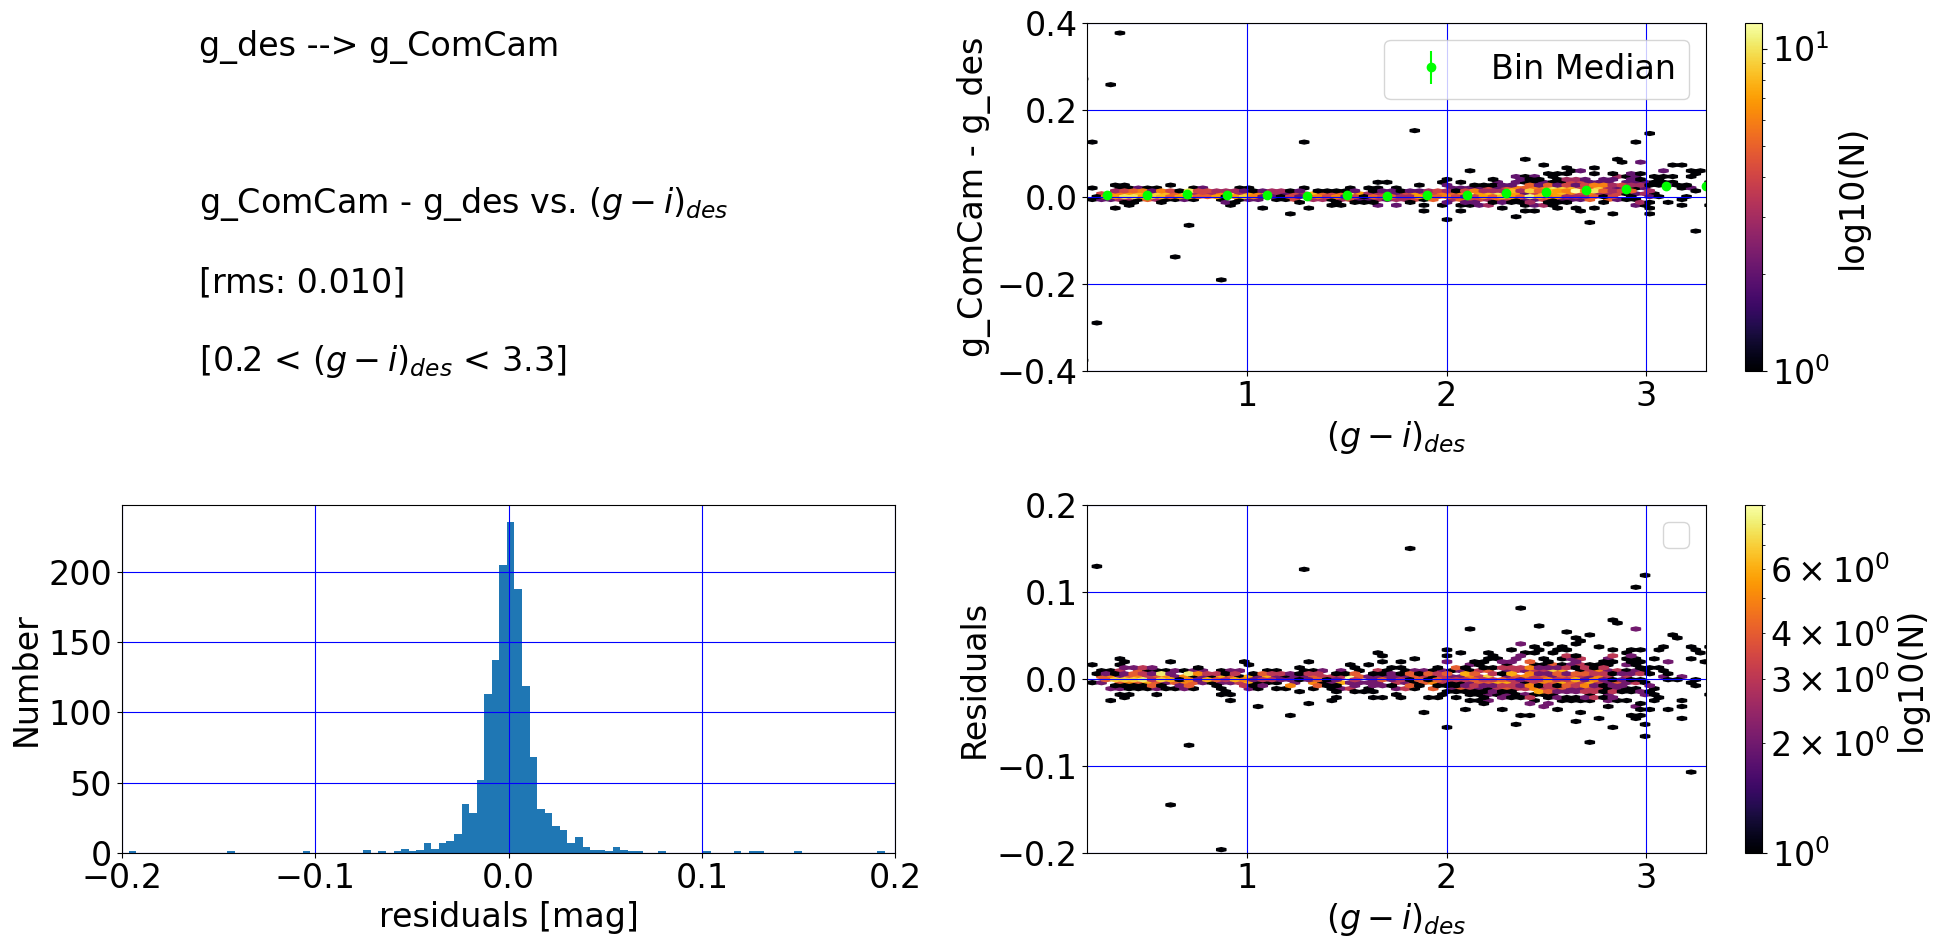

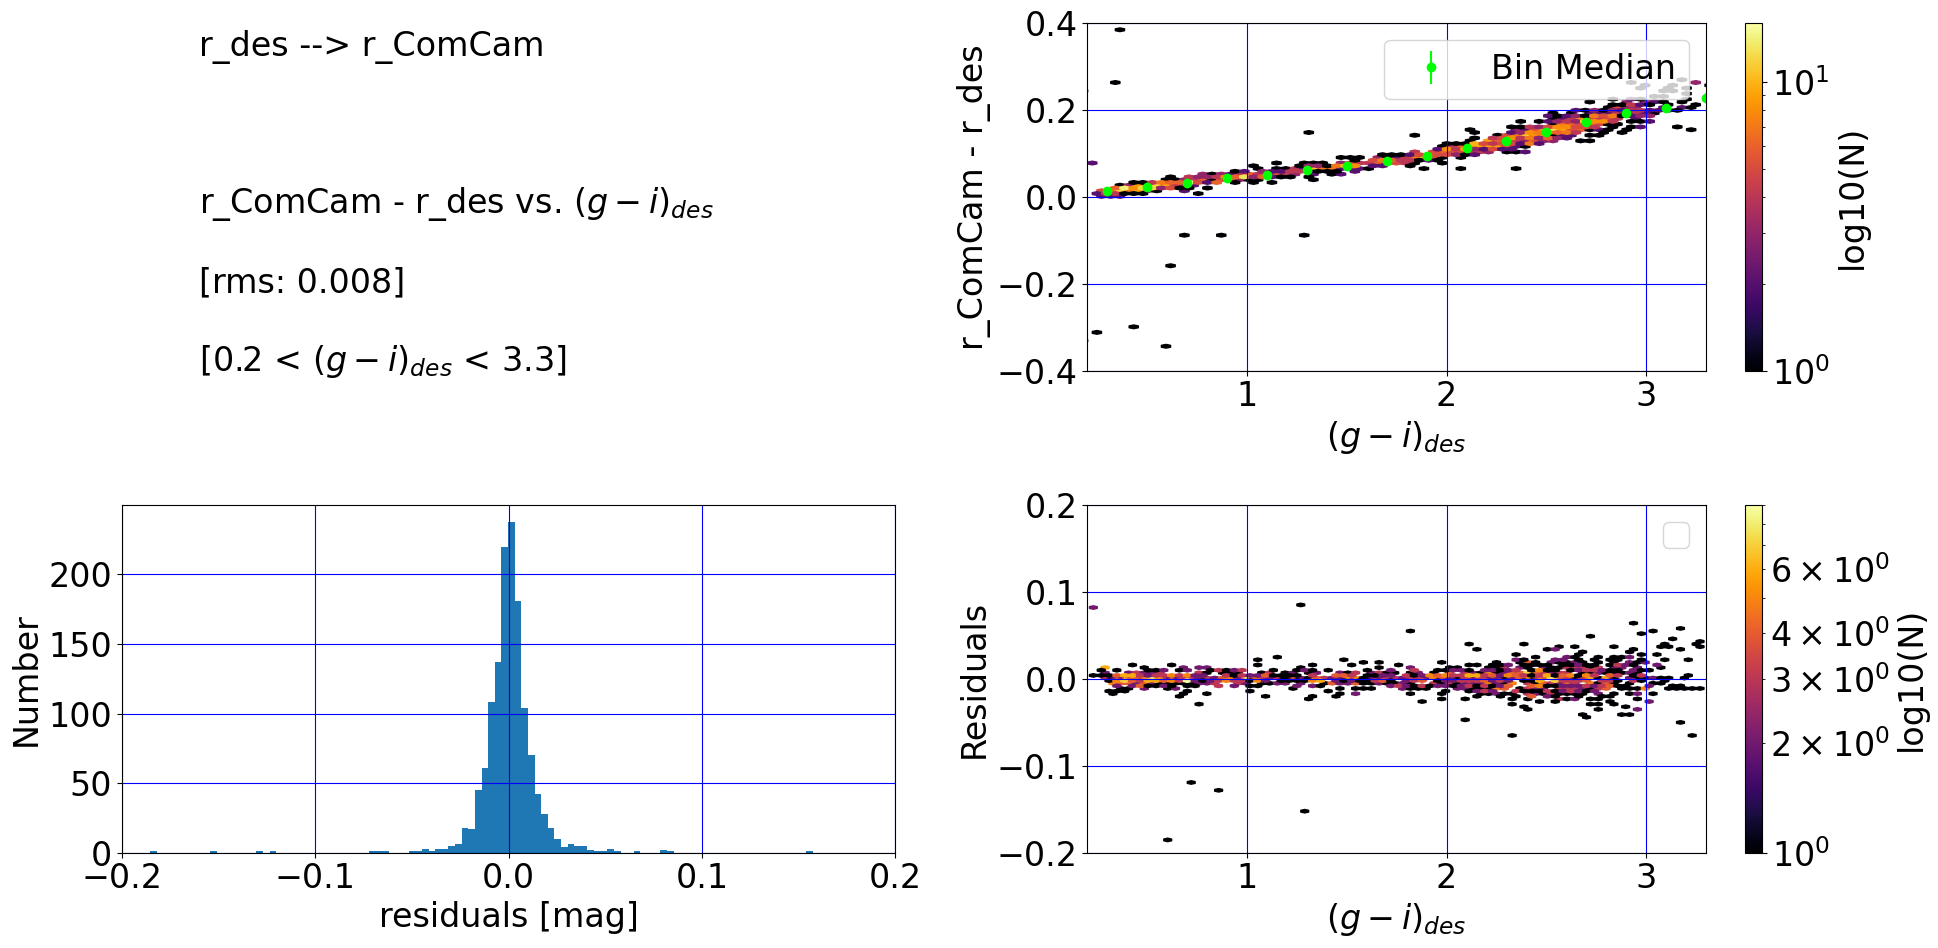

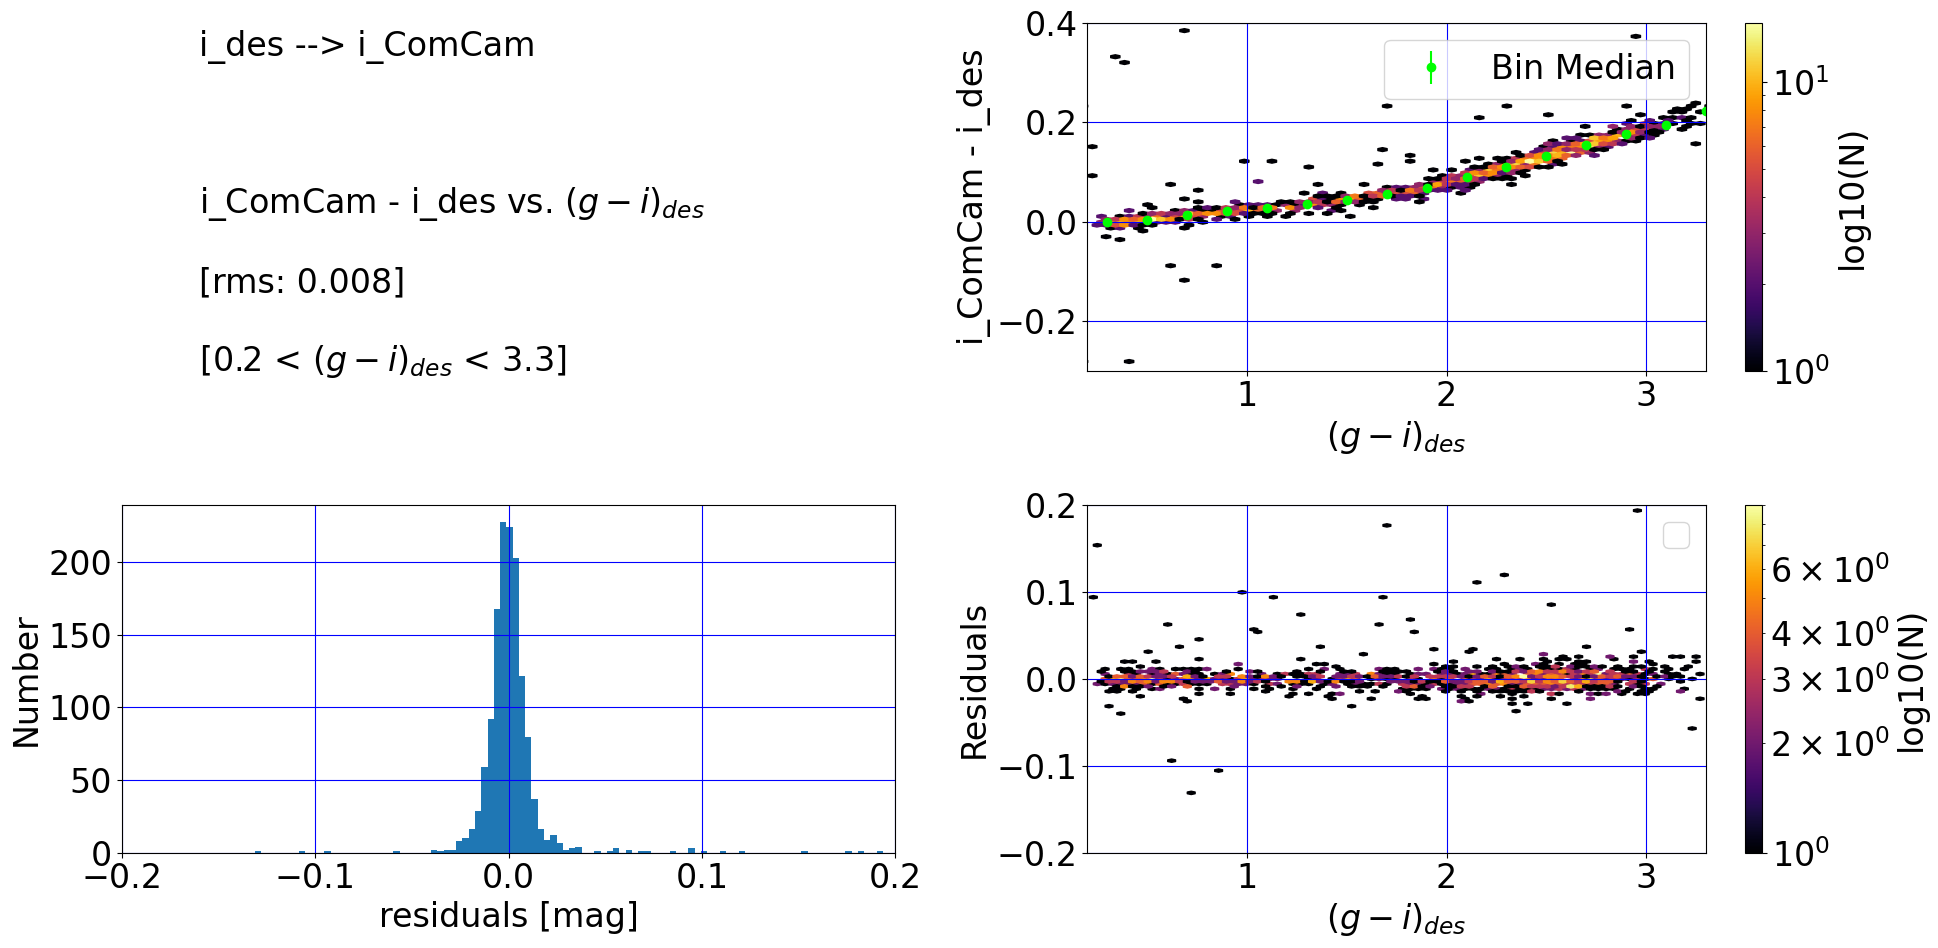

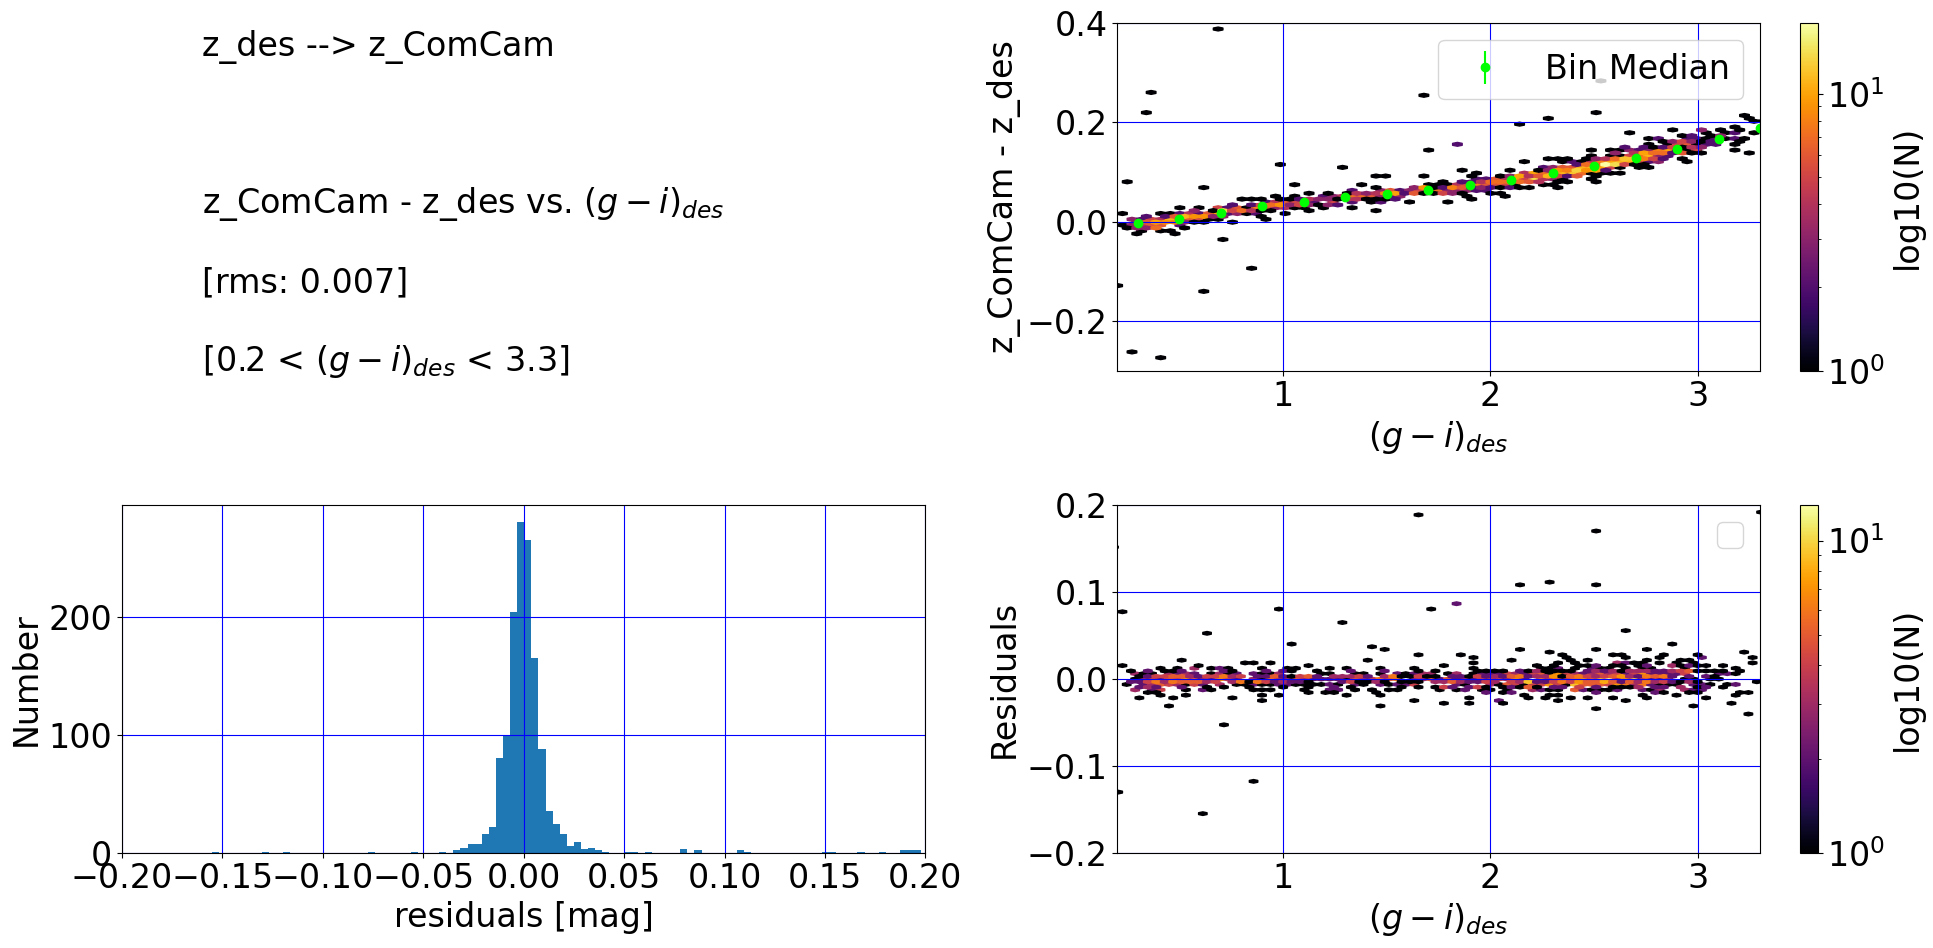

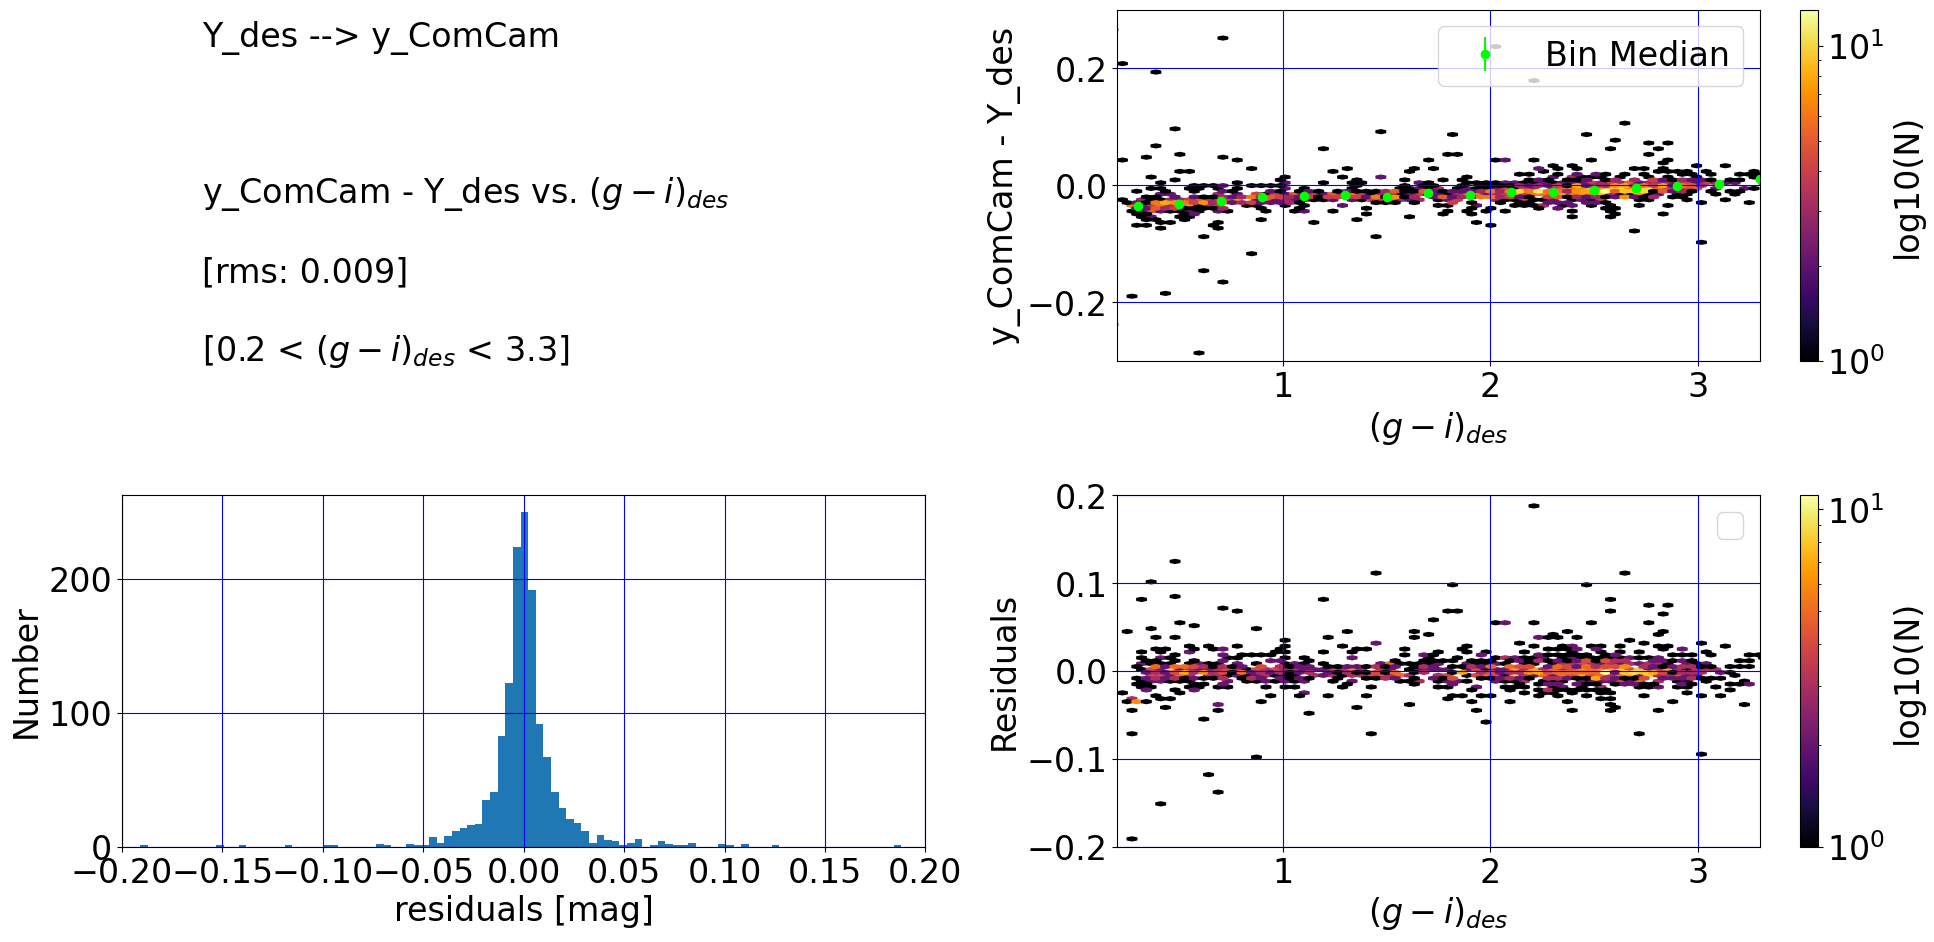

In [32]:
# --- Accumulator for ALL bands ---
qa_rows_all = []

# --- Main loop ---
for band in bandList:
    
    print("")
    print("")
    print("") 
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(band)
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print("")
    
    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) )
    mask = mask & mask1 & mask2

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag and color1 series...
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]


    # Calculate the color range to bin and the number of bins, 
    #  based on the 0.01%-99.99% color range...
    #color1_desc = df[color_name_1].describe(percentiles=[0.0001, 0.9999])
    #color1_min = math.floor(10*color1_desc['0.01%'])/10.
    #color1_max = math.ceil(10*color1_desc['99.99%'])/10.
    color1_desc = df[color_name_1].describe(percentiles=[0.01, 0.99])
    color1_min = math.floor(10*color1_desc['1%'])/10.
    color1_max = math.ceil(10*color1_desc['99%'])/10.
    if verbose>1:
        print("")
        print(color1_desc)
        print(color1_min, color1_max)
        print("")
    binsize = color_binsize
    ranges = np.arange(color1_min,color1_max+binsize,binsize)
    # Label the bins by their mid-point...
    labels = np.arange(color1_min,color1_max,binsize) + 0.5*binsize
    
    #nbins = int((color1_max-color1_min)/binsize)+1
    #ranges = np.linspace(color1_min, color1_max, nbins+1)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins) + 0.5*binsize

    #nbins = math.floor((color1_max-color1_min)/binsize) + 1
    #ranges = np.linspace(color1_min, color1_max, nbins)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins-1) + 0.5*binsize
    
    if verbose:
        print(ranges)
        print(labels)
    
    # Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
    df['bin_interval'] = pd.cut(df[color_name_1], bins=ranges, precision=0)
    df['bin_label'] = pd.cut(df[color_name_1], bins=ranges, labels=labels)
    if verbose>1:
        print("")
        print(df[[color_name_1,'bin_interval','bin_label']].head())
        print("")

    # Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
    df_grp = df.groupby(['bin_label'])
    bin_interval = df_grp['bin_interval'].first()
    dmag_num = df_grp['dmag'].count()
    dmag_mean = df_grp['dmag'].mean()
    dmag_sd = df_grp['dmag'].std()
    dmag_err = dmag_sd/np.sqrt(dmag_num-1)
    dmag_median = df_grp['dmag'].median()
    dmag_rsd = df_grp['dmag'].apply(robustStdDev)
    dmag_unc = np.sqrt(np.pi/2)*dmag_rsd/np.sqrt(dmag_num)
    #dmag_rsd = dmag_sd
    #dmag_unc = dmag_err

    # Rename some of the pandas series...
    dmag_num.name    = 'bin_num'
    dmag_mean.name   = 'bin_mean'
    dmag_sd.name     = 'bin_stddev'
    dmag_err.name    = 'bin_stderr'
    dmag_median.name = 'bin_median'
    dmag_rsd.name    = 'bin_rstddev'
    dmag_unc.name    = 'bin_unc'
    
    # Create new data frame containing all the relevant aggregate quantities...
    df1 = pd.concat( [bin_interval, dmag_num, \
                      dmag_mean, dmag_sd, dmag_err, \
                      dmag_median, dmag_rsd, dmag_unc, ], \
                    join='outer', axis=1 )
    
    if verbose>1:
        print("")
        print(df1)
        print("")
    
    
    # Create results output file...
    resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
    df1.to_csv(resultsFile)
    if verbose>1:
        print("""Writing binned values to %s""" % (resultsFile))

    
    # Create name for QA plot output file...
    outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)

    # Create title and labels for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagLabel = """%s - %s""" % (magName, magName_match)


    # Create QA plots...
    status = interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                                     title, dmagLabel, outputFileName, verbose)

    # Calculate the 'robust' RMS of the residuals....
    #rms_val = df1['bin_rstddev'].median()  # or mean, or df1['bin_unc'].median()
    rms_val = robustStdDev(df['res'].values)
    rms_val = round(rms_val, 3)

    conversion_str = make_conversion_str(magName_match, magName)
    range_str = make_range_str_interp(color1_min, color1_max, colorLabel_1)

    qa_rows_all.append({
        "Conversion": conversion_str,
        "RMS": rms_val,
        "Applicable Color Range": range_str,
        "QA Plot": f"[link](_static/plots/{outputFileName})",
        "Lookup Table": f"[link](_static/data/{resultsFile})"
    })


# --- After ALL bands processed: display one big table ---
if qa_rows_all:
    qa_df_all = pd.DataFrame(qa_rows_all)
    md_table_str = qa_df_all.to_markdown(index=False)
    md_table_str = md_table_str.replace(r'\_', '_')
    print(md_table_str)

    if write_md_file:
        with open(md_filename, "w") as f:
            f.write(md_table_str)
        print(f"\nMarkdown table written to: {md_filename}")
  